In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from portfolio_factor_allocation.backtesting import (
    calculate_annualized_volatility,
    calculate_information_ratio,
    calculate_sharpe_ratio,
    calculate_strategy_returns,
    calculate_studentized_sharpe_diff_stat,
    calculate_tracking_error,
)

In [2]:
data_dir = Path.cwd().parent / "data"
strategies_dir = data_dir / "strategies"
returns_dir = data_dir / "returns"
summary_dir = data_dir / "summary"

returns_dir.mkdir(parents=True, exist_ok=True)
summary_dir.mkdir(parents=True, exist_ok=True)

### Load data

Retrieve sample df_weights to be able to remove unnecessary companies from df_crsp

In [3]:
df_monthly_returns = pd.read_csv(data_dir / "monthly_returns.csv", parse_dates=["date"])
df_monthly_returns["date"] = df_monthly_returns["date"].dt.to_period("M")
df_monthly_rf = pd.read_csv(data_dir / "monthly_rf.csv", parse_dates=["date"])
df_monthly_rf["date"] = df_monthly_rf["date"].dt.to_period("M")

### Compute returns

In [4]:
factors = ["V", "W", "C", "R", "L"]
factor_combs = [
    list(c)
    for r in range(2, len(factors) + 1)
    for c in itertools.combinations(factors, r)
]

In [12]:
suffixes = [
    "_int_ter",
    "_mix_ter",
    "_int_dec",
    "_mix_dec",
    "_int_bw",
    "_mix_bw",
]
year_shift = -1
n_month_rebalance = 1
portfolios = ["ter", "dec", "bw"]
block_size = 5

In [13]:
df_weights = pd.read_csv(data_dir / "strategies" / "market.csv")

df_market_r = calculate_strategy_returns(
    df_weights, df_monthly_returns, year_shift, n_month_rebalance, ["market"]
)

df_market_r.to_csv(returns_dir / "market.csv", index=False)

In [14]:
vol_data = {}
sharpe_data = {}
ir_data = {}
te_data = {}
studentized_data = {}

# Ensure market returns are indexed by date for alignment
market_series = df_market_r.set_index("date")["market"]
rf_series = df_monthly_rf.set_index("date")["rf"]

for factor_comb in factor_combs:
    factor_str = "_".join(factor_comb)
    weights_cols = [factor_str + s for s in suffixes]
    df_weights = pd.read_csv(strategies_dir / f"{factor_str}.csv")

    df_r = calculate_strategy_returns(
        df_weights, df_monthly_returns, year_shift, n_month_rebalance, weights_cols
    )

    df_r.to_csv(returns_dir / f"{factor_str}.csv", index=False)

    # Calculate stats
    df_r_indexed = df_r.set_index("date")

    # Align with market and rf
    # We need to align all three: strategy returns, market returns, and risk-free rate
    # to ensure we are calculating metrics on the exact same set of dates.
    common_index = df_r_indexed.index.intersection(market_series.index).intersection(
        rf_series.index
    )

    aligned_r = df_r_indexed.loc[common_index]
    aligned_m = market_series.loc[common_index]
    aligned_rf = rf_series.loc[common_index]

    # Calculate Excess Returns for Studentized Statistic
    excess_r = aligned_r.sub(aligned_rf, axis=0)

    vols = {}
    sharpes = {}
    irs = {}
    tes = {}

    for col, suffix in zip(weights_cols, suffixes):
        # Returns for this strategy
        r = aligned_r[col]

        # Vol
        vols[suffix] = calculate_annualized_volatility(r)

        # Sharpe
        sharpes[suffix] = calculate_sharpe_ratio(r, aligned_rf)

        # IR
        irs[suffix] = calculate_information_ratio(r, aligned_m)

        # TE
        tes[suffix] = calculate_tracking_error(r, aligned_m)

    vol_data[factor_str] = vols
    sharpe_data[factor_str] = sharpes
    ir_data[factor_str] = irs
    te_data[factor_str] = tes

    # Calculate Studentized Statistics for Int vs Mix
    for port in portfolios:
        col_int = f"{factor_str}_int_{port}"
        col_mix = f"{factor_str}_mix_{port}"

        if col_int in excess_r.columns and col_mix in excess_r.columns:
            r_i = excess_r[col_int]
            r_n = excess_r[col_mix]

            stat = calculate_studentized_sharpe_diff_stat(r_i, r_n, block_size)

            if port not in studentized_data:
                studentized_data[port] = {}
            studentized_data[port][factor_str] = stat

df_vol = pd.DataFrame(vol_data)
df_sharpe = pd.DataFrame(sharpe_data)
df_ir = pd.DataFrame(ir_data)
df_te = pd.DataFrame(te_data)
df_studentized = pd.DataFrame(studentized_data).T

df_vol.to_csv(summary_dir / "vol_summary.csv")
df_sharpe.to_csv(summary_dir / "sharpe_summary.csv")
df_ir.to_csv(summary_dir / "ir_summary.csv")
df_te.to_csv(summary_dir / "te_summary.csv")
df_studentized.to_csv(summary_dir / "studentized.csv")

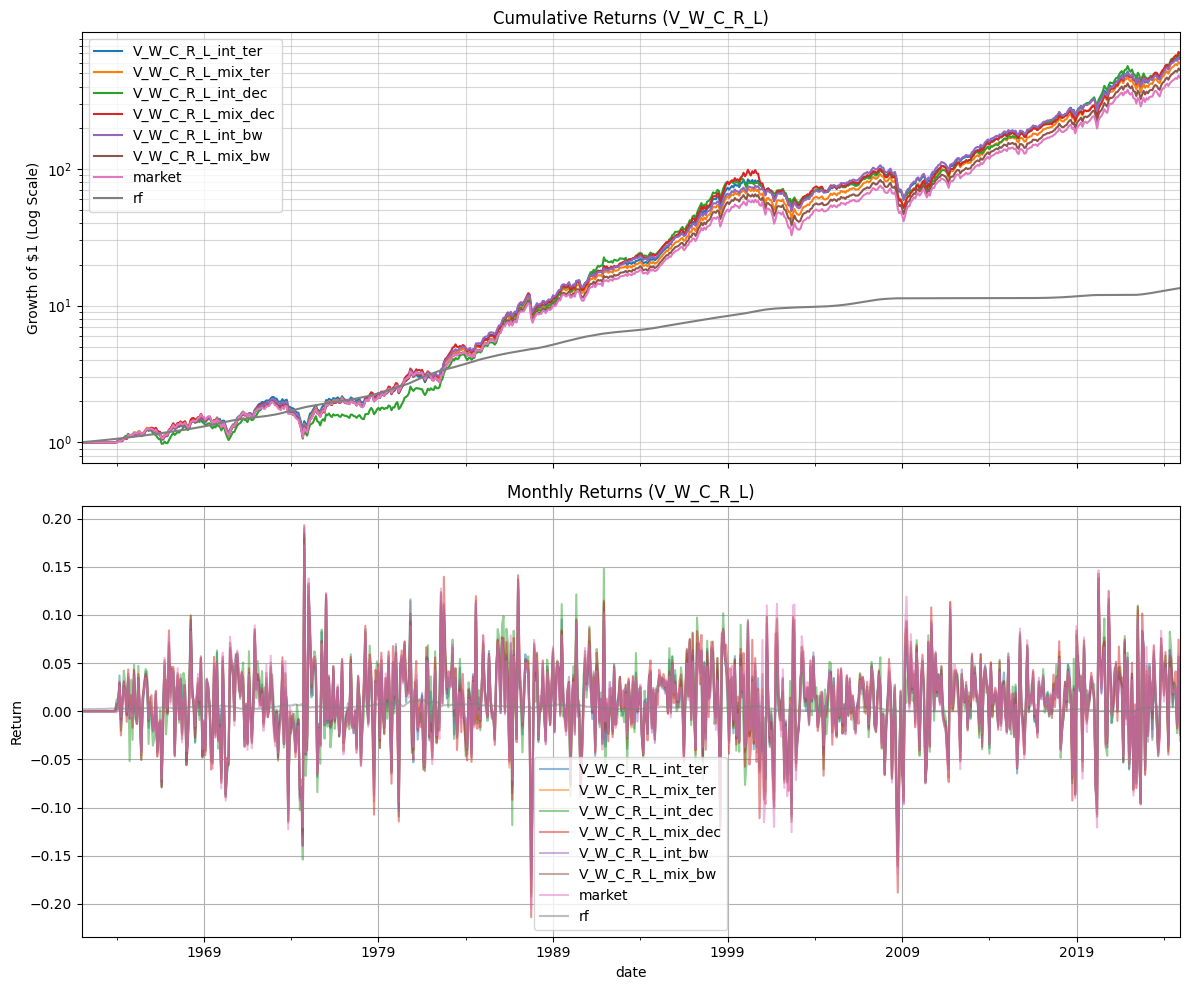

In [18]:
# Plotting the last processed factor combination
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Prepare data
# Join strategy returns with market returns
df_plot = df_r.set_index("date").join(df_market_r.set_index("date"), how="inner")
df_plot = df_plot.join(df_monthly_rf.set_index("date"), how="inner")
df_cum = (1 + df_plot).cumprod()

# Cumulative Returns (Log Scale)
df_cum.plot(ax=axes[0], title=f"Cumulative Returns ({factor_str})", logy=True)
axes[0].set_ylabel("Growth of $1 (Log Scale)")
axes[0].grid(True, which="both", ls="-", alpha=0.5)

# Monthly Returns
df_plot.plot(ax=axes[1], title=f"Monthly Returns ({factor_str})", alpha=0.5)
axes[1].set_ylabel("Return")
axes[1].grid(True)

plt.tight_layout()
plt.show()

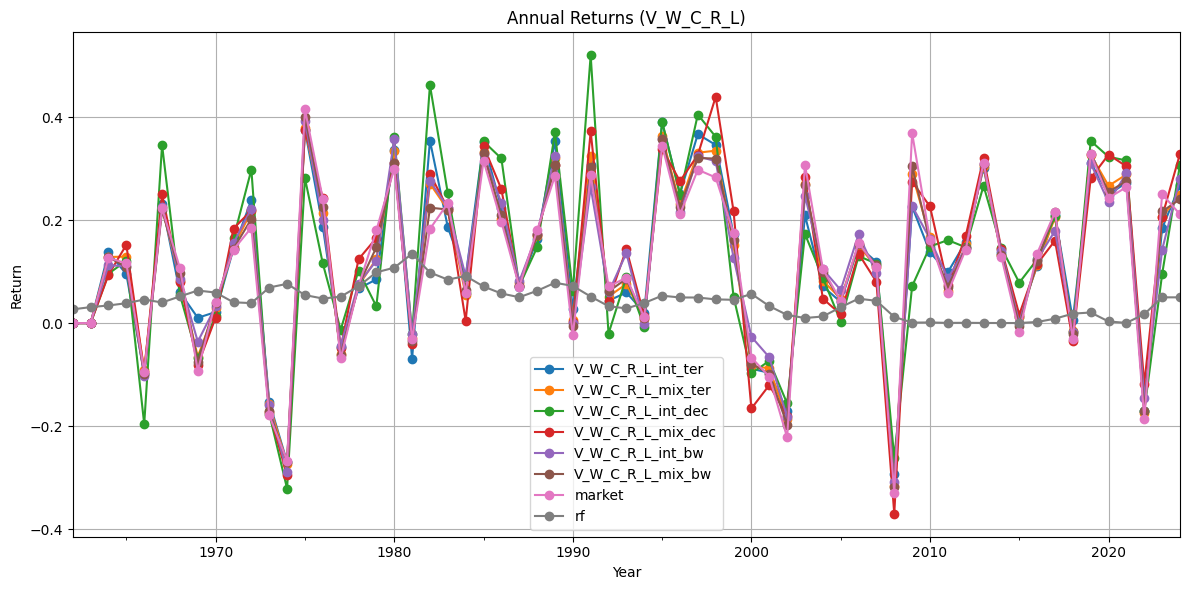

In [19]:
# Annual Returns
# Resample to annual frequency and compound returns
df_annual = (1 + df_plot).resample("Y").prod() - 1

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df_annual.plot(ax=ax, title=f"Annual Returns ({factor_str})", marker="o")
ax.set_ylabel("Return")
ax.set_xlabel("Year")
ax.grid(True)
plt.tight_layout()
plt.show()

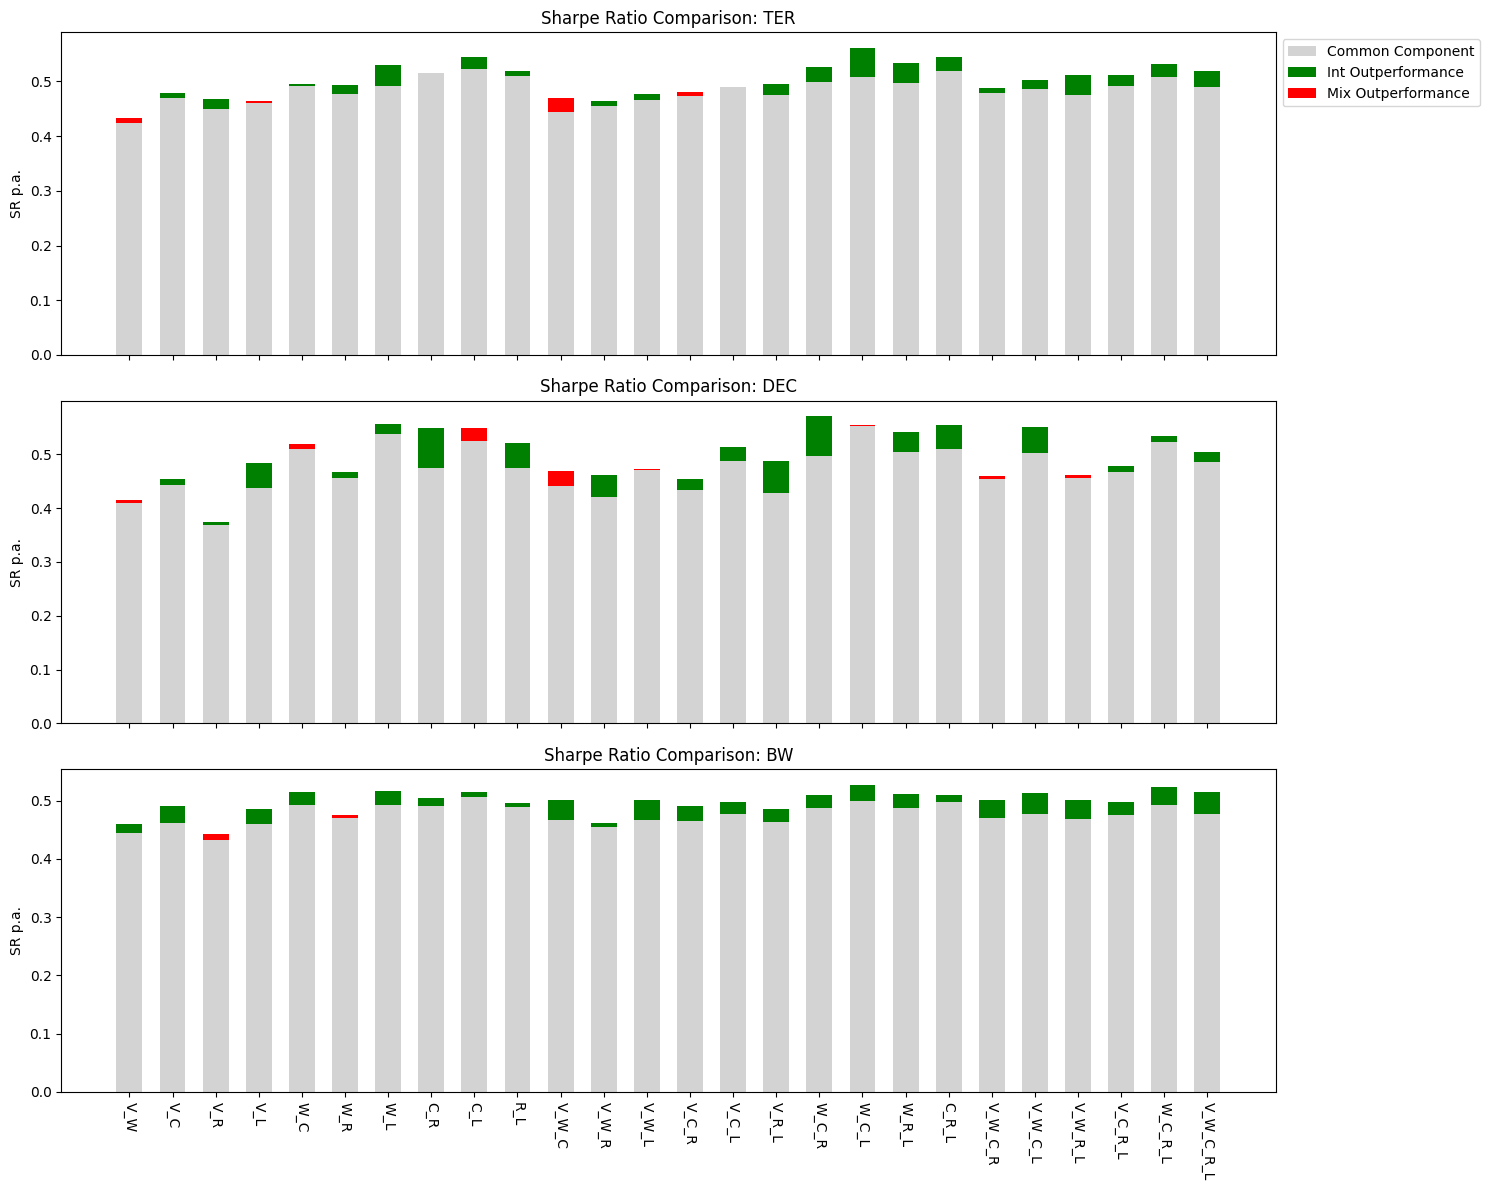

In [20]:
def plot_sharpe_comparison(df_sharpe, factor_combs, portfolios):
    """
    Plots a comparison of Sharpe Ratios for Integrated vs Mixed strategies.

    Args:
        df_sharpe (pd.DataFrame): DataFrame containing Sharpe Ratios.
                                  Columns are factor combinations (e.g., "V_W").
                                  Rows are strategy suffixes (e.g., "_int_ter", "_mix_ter").
        factor_combs (list): List of factor combinations to plot (e.g., ["V_W", "V_C"]).
        portfolios (list): List of portfolio types to compare (e.g., ["TER", "DEC", "BW"]).
                           Assumes suffixes are formatted as f"_int_{lower(portfolio)}" and f"_mix_{lower(portfolio)}".
    """

    n_portfolios = len(portfolios)
    n_factors = len(factor_combs)

    fig, axes = plt.subplots(
        n_portfolios, 1, figsize=(15, 4 * n_portfolios), sharex=True
    )
    if n_portfolios == 1:
        axes = [axes]

    # Colors
    color_int = "#d3d3d3"  # Light grey for Integrated
    color_pos_diff = "green"  # Green for positive difference (Int > Mix)
    color_neg_diff = "red"  # Red for negative difference (Int < Mix)

    for i, portfolio in enumerate(portfolios):
        ax = axes[i]
        suffix_int = f"_int_{portfolio.lower()}"
        suffix_mix = f"_mix_{portfolio.lower()}"

        # Extract data for this portfolio type across all factors
        sr_int = []
        sr_mix = []
        labels = []

        for factor in factor_combs:
            if factor in df_sharpe.columns:
                # Check if rows exist
                if suffix_int in df_sharpe.index and suffix_mix in df_sharpe.index:
                    sr_int.append(df_sharpe.loc[suffix_int, factor])
                    sr_mix.append(df_sharpe.loc[suffix_mix, factor])
                    labels.append(factor)

        x = np.arange(len(labels))
        width = 0.6

        sr_int = np.array(sr_int)
        sr_mix = np.array(sr_mix)

        # Plot Integrated bars (base)
        ax.bar(x, sr_int, width, label="Integrated", color=color_int)

        # Calculate difference
        diff = sr_int - sr_mix

        # Base is the minimum of the two
        base = np.minimum(sr_int, sr_mix)

        # Difference arrays
        diff_pos = np.maximum(sr_int - sr_mix, 0)  # Int > Mix
        diff_neg = np.maximum(sr_mix - sr_int, 0)  # Mix > Int

        # Plot Base (Grey)
        ax.bar(x, base, width, color=color_int, label="Base (Min)")

        # Plot Positive Diff (Green) - Stacked on Base
        # This represents the extra SR of Int over Mix
        ax.bar(x, diff_pos, width, bottom=base, color=color_pos_diff, label="Int > Mix")

        # Plot Negative Diff (Red) - Stacked on Base
        # This represents the extra SR of Mix over Int
        ax.bar(x, diff_neg, width, bottom=base, color=color_neg_diff, label="Mix > Int")

        ax.set_ylabel("SR p.a.")
        ax.set_title(f"Sharpe Ratio Comparison: {portfolio}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=270)

        # Only add legend to the first plot to avoid clutter
        if i == 0:
            # Custom legend
            from matplotlib.patches import Patch

            legend_elements = [
                Patch(facecolor=color_int, label="Common Component"),
                Patch(facecolor=color_pos_diff, label="Int Outperformance"),
                Patch(facecolor=color_neg_diff, label="Mix Outperformance"),
            ]
            ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


# Get all factor combinations from the dataframe columns
all_factors = df_sharpe.columns.tolist()
portfolios_to_plot = ["TER", "DEC", "BW"]  # Add "TE" if you have it

plot_sharpe_comparison(df_sharpe, all_factors, portfolios_to_plot)